In [138]:
!pip install scikit-surprise


In [155]:
#Import necessary libraries
import pandas as pd
import numpy as np
from surprise import SVD
import surprise
from surprise import Reader, Dataset
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [140]:
train_data=pd.read_csv('ratings.csv')

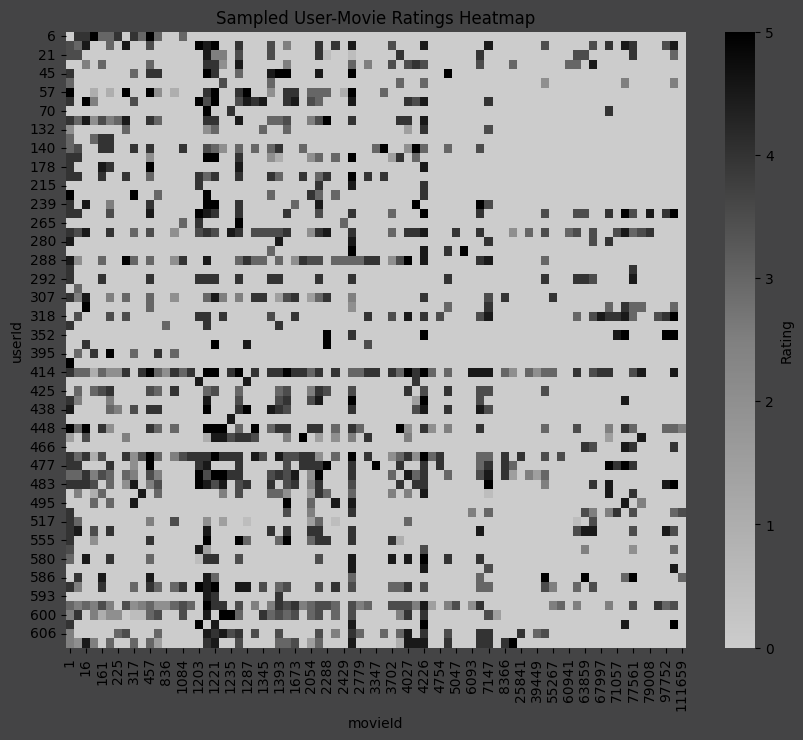

In [141]:
# Randomly sample a subset of users and movies
sample_users = train_data['userId'].sample(n=80)
sample_movies = train_data['movieId'].sample(n=80)

# Create a pivot table for the sampled user-movie ratings
sampled_ratings_pivot = train_data[(train_data['userId'].isin(sample_users)) & (train_data['movieId'].isin(sample_movies))] \
    .pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)

# Plot heatmap for userId movieId ratings
plt.figure(figsize=(10,8))
custom_colormap = LinearSegmentedColormap.from_list('custom_colormap', ['#CCCCCC', '#808080', '#000000'], N=256)

sns.heatmap(sampled_ratings_pivot, cmap=custom_colormap, cbar_kws={'label': 'Rating'})
plt.title('Sampled User-Movie Ratings Heatmap')
plt.gcf().set_facecolor('#444445')
plt.show()

In [142]:
final_data=pd.DataFrame()
final_data['user'] = list(train_data['userId'])
final_data['movie'] = list(train_data['movieId'])

In [143]:
# It is to specify how to read the data frame.
reader = Reader(rating_scale=(1,5))

# create the traindata from the data frame
train_data_mf = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

# build the train set from traindata.
trainset = train_data_mf.build_full_trainset()
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd.fit(trainset)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [144]:
#getting predictions of train set
train_preds = svd.test(trainset.build_testset())
train_pred_mf = np.array([pred.est for pred in train_preds])
final_data['lightfm_predictions'] = train_pred_mf

In [145]:
# Creating a sparse matrix
train_sparse_matrix = sparse.csr_matrix((train_data.rating.values, (train_data.userId.values, train_data.movieId.values)))

In [146]:
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
final_data['global'] = [train_global_average]*len(train_data['userId'])

#average rating
def get_average_ratings(sparse_matrix, of_users):
  # average ratings of user/axes
  ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes
  # ".A1" is for converting Column_Matrix to 1-D numpy array
  sum_of_ratings = sparse_matrix.sum(axis=ax).A1
  # Boolean matrix of ratings ( whether a user rated that movie or not)
  is_rated = sparse_matrix!=0
  # no of ratings that each user OR movie..
  no_of_ratings = is_rated.sum(axis=ax).A1
  # max_user and max_movie ids in sparse matrix
  u,m = sparse_matrix.shape
  # create a dictionary of users and their average ratings..
  average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
  for i in range(u if of_users else m)
  if no_of_ratings[i] !=0}
  #return that dictionary of average ratings
  return average_ratings

In [147]:
#Collect user averages
train_averages=dict()
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)

In [148]:
#Collect movie averages
train_averages['movie'] = get_average_ratings(train_sparse_matrix, of_users=False)

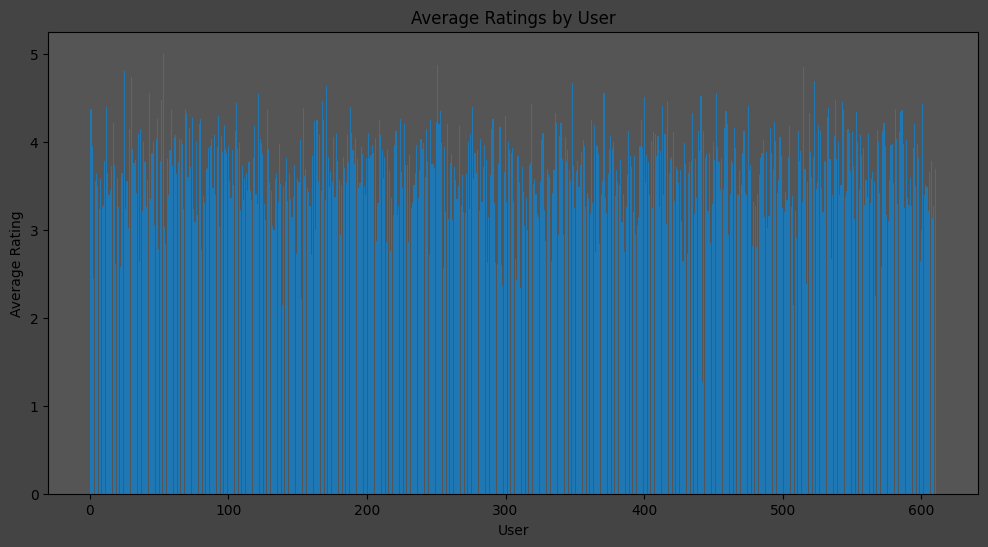

In [149]:
# Plot bar chart for user average ratings
plt.figure(figsize=(12, 6))
plt.bar(train_averages['user'].keys(), train_averages['user'].values())
plt.title('Average Ratings by User')
plt.xlabel('User')
plt.ylabel('Average Rating')
plt.gcf().set_facecolor('#444445')
plt.gca().set_facecolor('#555555')

plt.show()

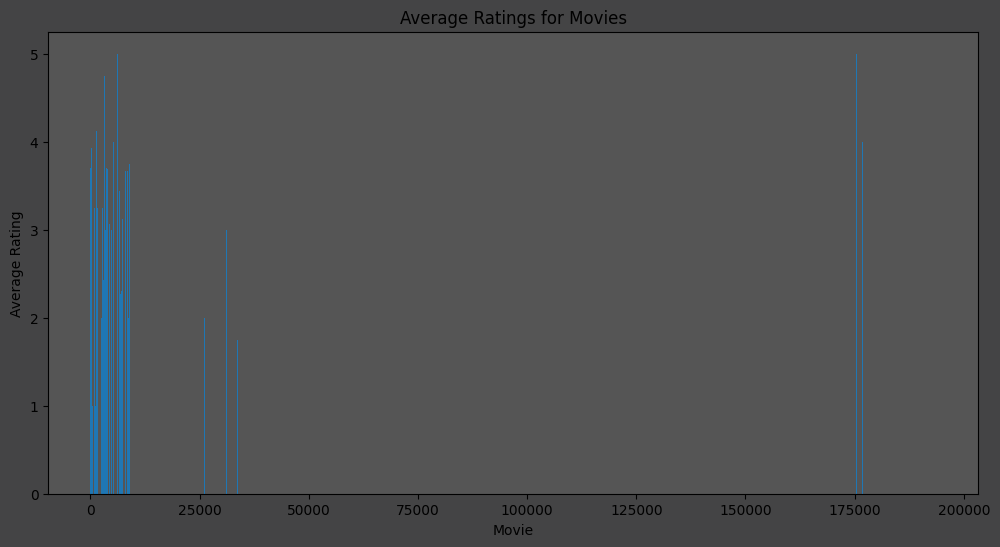

In [150]:
# Plot bar chart for movie average ratings
plt.figure(figsize=(12, 6))
plt.bar(train_averages['movie'].keys(), train_averages['movie'].values())
plt.title('Average Ratings for Movies')
plt.xlabel('Movie')
plt.ylabel('Average Rating')
plt.gcf().set_facecolor('#444445')
plt.gca().set_facecolor('#555555')
plt.show()

In [151]:
final_data['user_avg']= pd.to_numeric(list(map(train_averages.get, final_data['user'])), errors='coerce')
final_data['movie_avg']= pd.to_numeric(list(map(train_averages.get, final_data['movie'])), errors='coerce')
final_data['rating']= train_data['rating']

In [152]:
def filler(row):
  user, movie = int(row['user']), int(row['movie'])
  # compute the similar Users of the "user"
  user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
  top_sim_users = user_sim.argsort()[::-1][1:]
  # Make it's length "5" by adding movie averages to
  top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
  top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
  top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 -len(top_sim_users_ratings)))
  # compute the similar movies of the "movie"
  movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T,train_sparse_matrix.T).ravel()
  top_sim_movies = movie_sim.argsort()[::-1][1:]
  top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
  # Make it's length "5" by adding user averages to it
  top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
  top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
  return top_sim_users_ratings+top_sim_movies_ratings

In [153]:
users=[]
movies=[]
for i in range(5):
  users.append(f'sim_user{i+1}')
  movies.append(f'sim_movie{i+1}')
all = users+movies

In [ ]:
## Runtime around 20-30mins. Can skip this and use final_data.csv
result = final_data.apply(lambda row: pd.Series(filler(row)), axis=1, result_type='expand')
result.columns= all
final_data = pd.concat([final_data, result], axis=1)

In [157]:
# Save the final data
final_data.to_csv('final_data.csv', index=False)

In [158]:
# if saved
final_data = pd.read_csv('final_data.csv')

In [159]:
x = final_data.drop(['user', 'movie','rating'], axis=1)
y = final_data['rating']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test= train_test_split(x_test, y_test, test_size=0.5, random_state=42)

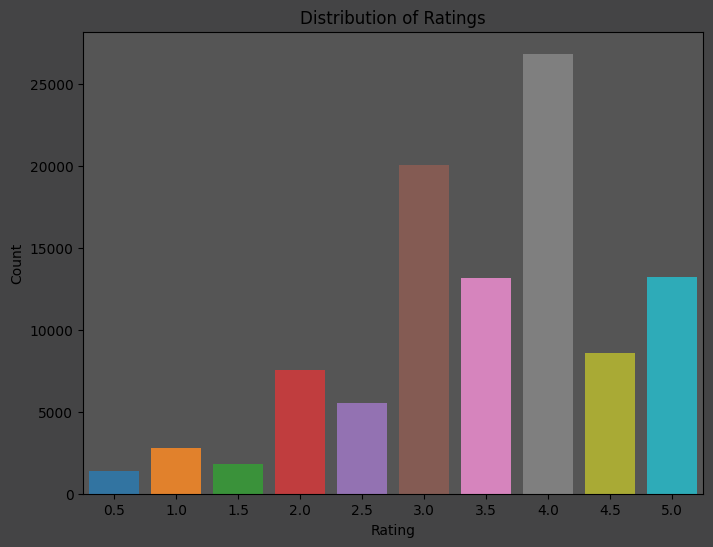

In [160]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=train_data)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.gcf().set_facecolor('#444445')
plt.gca().set_facecolor('#555555')
plt.show()


In [161]:
# initialize XGBoost model
xgb_model = xgb.XGBRegressor(silent=False, n_jobs=13,random_state=15,n_estimators=100)
# fit the model
xgb_model.fit(x_train, y_train, eval_set=[(x_val, y_val)], eval_metric='rmse',verbose=False)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:12:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=13,
             num_parallel_tree=None, random_state=15, ...)

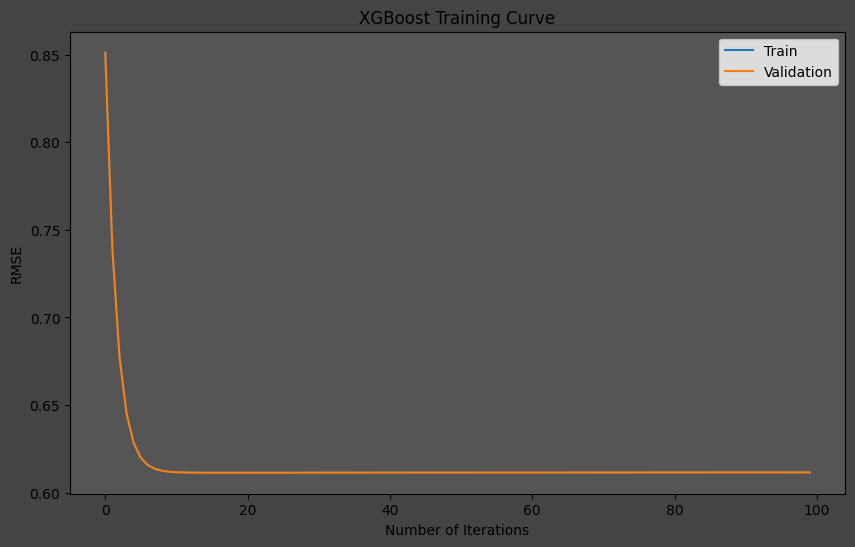

In [162]:
# Access the training results from xgb_model
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Plot RMSE for training data and validation data
plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_0']['rmse'], label='Validation')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('XGBoost Training Curve')
plt.legend()
plt.gcf().set_facecolor('#444445')
plt.gca().set_facecolor('#555555')
plt.show()


In [163]:
#dictionaries for storing train and test results
test_results = dict()
# from the trained model, get the predictions
y_test_pred = xgb_model.predict(x_test)
# get the rmse and mape of train data
rmse = np.sqrt(np.mean([ (y_test.values[i] - y_test_pred[i])**2 for i in
range(len(y_test_pred)) ]))
mape = np.mean(np.abs( (y_test.values- y_test_pred)/y_test.values )) * 100
# store the results in train_results dictionary
test_results = {'rmse': rmse, 'mape' : mape, 'predictions' : y_test_pred}
print(test_results)

{'rmse': 0.6181578952884217, 'mape': 19.494081559608826, 'predictions': array([3.8802485, 4.107036 , 2.0832407, ..., 4.5268383, 2.6030781,
       3.192878 ], dtype=float32)}


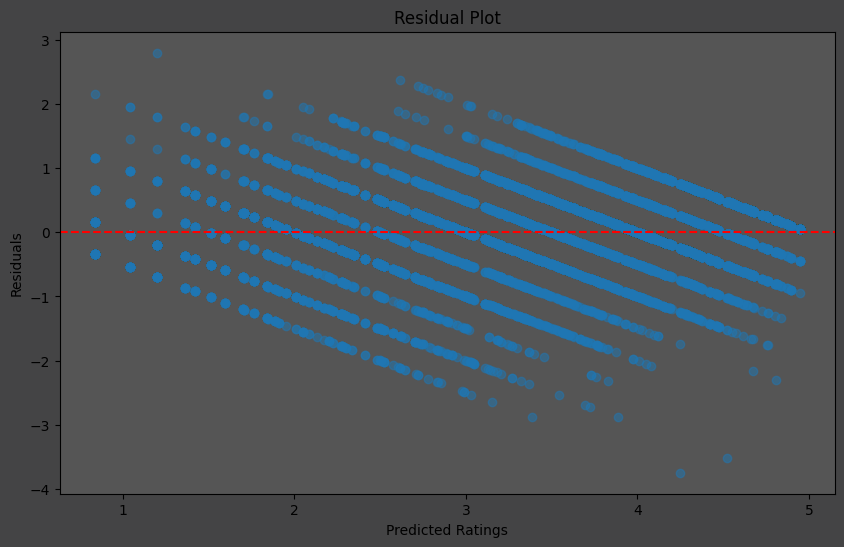

In [164]:
# Calculate residuals
residuals = y_test - y_test_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.gcf().set_facecolor('#444445')
plt.gca().set_facecolor('#555555')
plt.show()


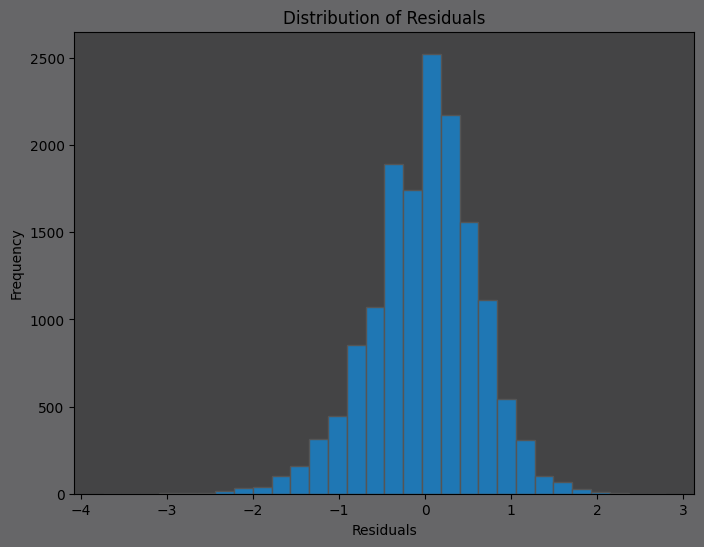

In [165]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='#555555')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.gcf().set_facecolor('#666668')
plt.gca().set_facecolor('#444445')
plt.show()

  Inspiration:
  https://towardsdatascience.com/how-to-build-a-movie-recommendation-system-67e321339109